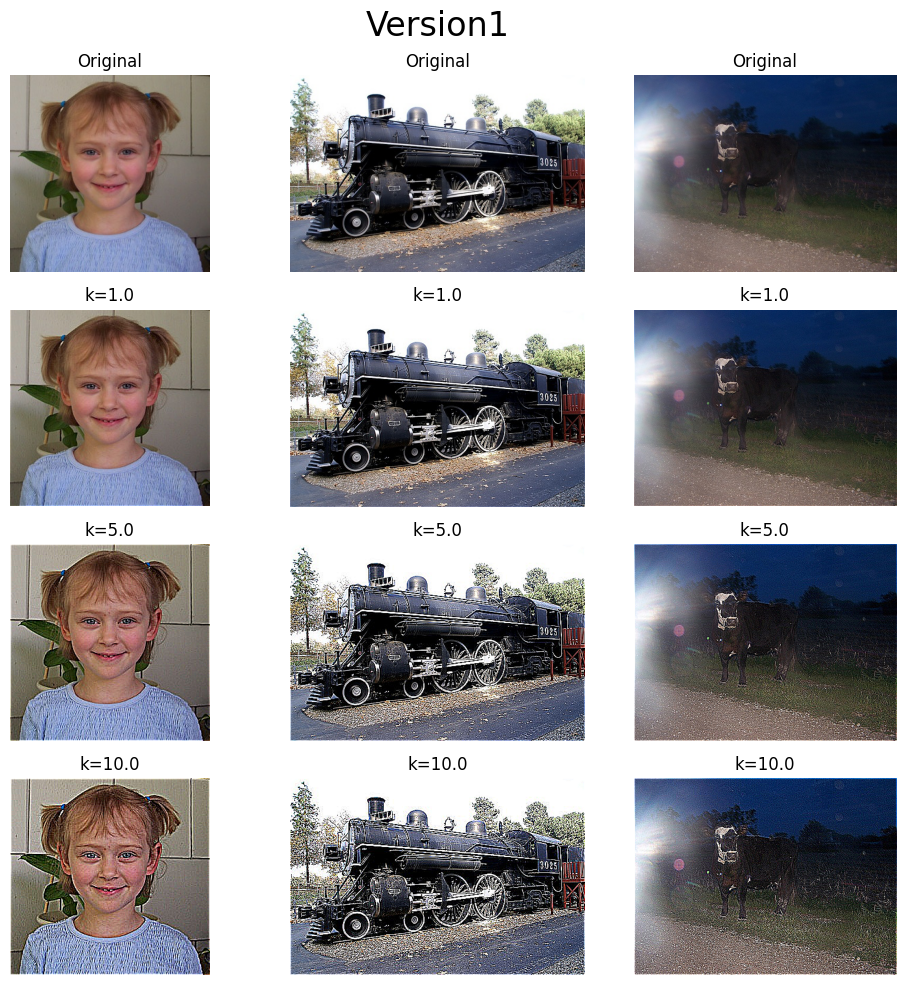

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class DepthwiseConvModel(nn.Module):
    def __init__(self):
        super(DepthwiseConvModel, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=5, padding=2, groups=3, bias=False)
        
    def forward(self, x, k):
        x1 = self.depthwise_conv(x)  
        return x + k * (x - x1) 

def get_gaussian_kernel(kernel_size=5, sigma=1.0):
    ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = torch.meshgrid([ax, ax], indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel
    
def img2tesor(img):
    transform = transforms.Compose([transforms.ToTensor()])
    img_tensor = transform(img).unsqueeze(0)  
    return img_tensor
    
def tesor2img(tesor):
    tensor_img= tesor.squeeze().permute(1, 2, 0).numpy()
    tensor_img= np.clip(tensor_img * 255, 0, 255).astype(np.uint8)
    return tensor_img

def show_img(img,rows, cols, index,title):
    plt.subplot(rows, cols, index)
    plt.imshow(img)
    plt.title(title)
    plt.axis(False)


output_images = []
original_images = []

def gaussian_blur_operation(img_source):
    img = cv2.imread(img_source)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_images.append(img)
    tensor=img2tesor(img)
    
    model = DepthwiseConvModel()
    model.eval() 
    k_values = [1.0, 5.0, 10.0]
    
    with torch.no_grad():
        kernel = get_gaussian_kernel(5, 1.0)
        weight = kernel.expand(3, 1, 5, 5).clone()
        model.depthwise_conv.weight.copy_(weight)
        for k in k_values:
            output = model(tensor, torch.tensor([[k]]))
            output_images.append(tesor2img(output))
            
img_paths = [
    "./input/TestImage1.jpg",
    "./input/TestImage2.jpg",
    "./input/TestImage3.jpg"
]

for path in img_paths:
    gaussian_blur_operation(path)

plt.figure(figsize=(10, 10))
plt.suptitle("Version1",fontsize=24)
titles = ["Original", "k=1.0", "k=5.0", "k=10.0"]

for i in range(3):
    show_img(original_images[i],4, 3, 1 + i , titles[0])
    for j in range(3):  
        idx = i * 3 + j
        show_img(output_images[idx], 4, 3, 4 + i + j*3, titles[j + 1])

plt.tight_layout()
plt.savefig("./output/Version1.jpg")
plt.show()

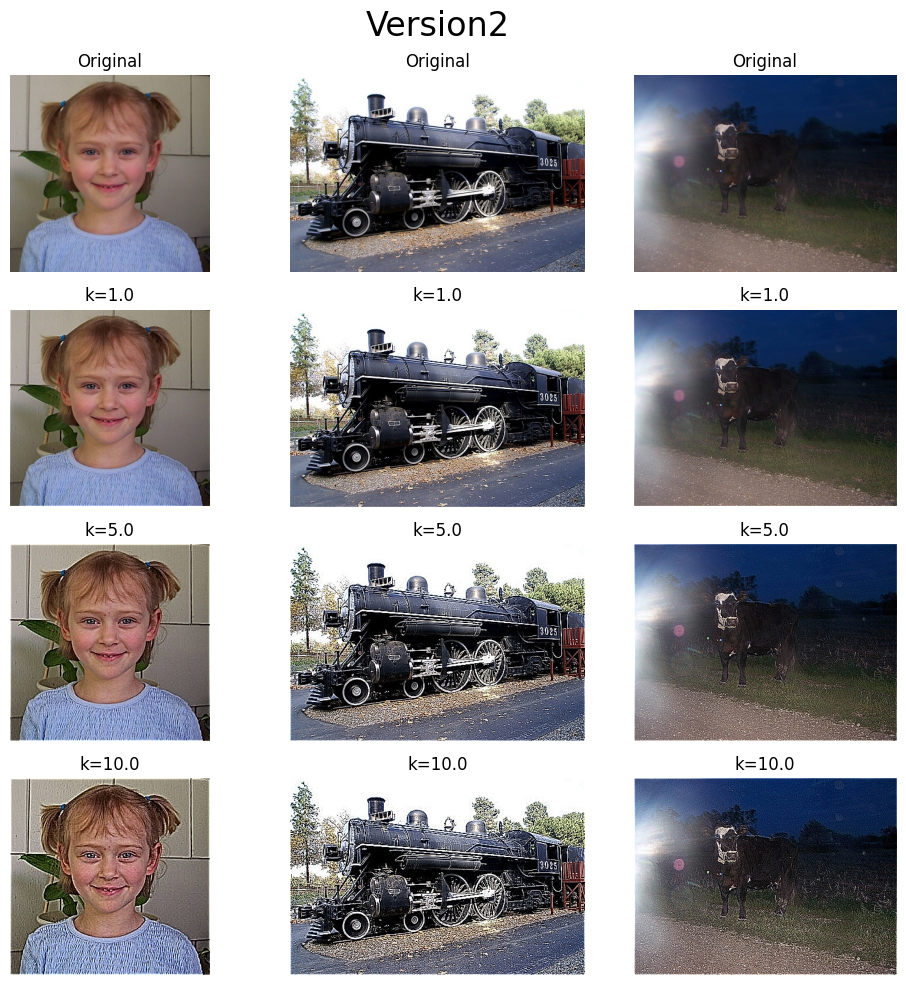

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class DepthwiseConvModel(nn.Module):
    def __init__(self):
        super(DepthwiseConvModel, self).__init__()
        self.depthwise_conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5, padding=2, groups=1, bias=False)
        
    def forward(self, x, k):
        x1 = self.depthwise_conv(x)
        return x + k * (x - x1)

def get_gaussian_kernel(kernel_size=5, sigma=1.0):
    ax = torch.arange(-kernel_size // 2 + 1., kernel_size // 2 + 1.)
    xx, yy = torch.meshgrid([ax, ax], indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    kernel = kernel / kernel.sum()
    return kernel

def img2tesor(img):
    transform = transforms.ToTensor()
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

def tensor2img(tensor):
    tensor_img = tensor.squeeze().permute(1, 2, 0).numpy()
    tensor_img = np.clip(tensor_img * 255, 0, 255).astype(np.uint8)
    return tensor_img

def tensor2grayimg(tensor):
    tensor_img = tensor.squeeze().numpy()
    tensor_img = np.clip(tensor_img * 255, 0, 255).astype(np.uint8)
    return tensor_img

def show_img(img, rows, cols, index, title):
    plt.subplot(rows, cols, index)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

output_images = []
original_images = []

def gaussian_blur_operation_yuv(img_source):
    img = cv2.imread(img_source)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_images.append(img_rgb)

    img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
    y, u, v = cv2.split(img_yuv)

    y_tensor = torch.from_numpy(y).float().div(255.0).unsqueeze(0).unsqueeze(0) 

    model = DepthwiseConvModel()
    model.eval()

    k_values = [1.0, 5.0, 10.0]

    with torch.no_grad():
        kernel = get_gaussian_kernel(5, 1.0)
        weight = kernel.expand(1, 1, 5, 5).clone()
        model.depthwise_conv.weight.copy_(weight)

        for k in k_values:
            y_processed = model(y_tensor, torch.tensor([[k]]))
            y_img = tensor2grayimg(y_processed)

            merged_yuv = cv2.merge([y_img, u, v])
            merged_rgb = cv2.cvtColor(merged_yuv, cv2.COLOR_YUV2RGB)
            output_images.append(merged_rgb)

img_paths = [
    "./input/TestImage1.jpg",
    "./input/TestImage2.jpg",
    "./input/TestImage3.jpg"
]

for path in img_paths:
    gaussian_blur_operation_yuv(path)

plt.figure(figsize=(10, 10))
plt.suptitle("Version2",fontsize=24)
titles = ["Original", "k=1.0", "k=5.0", "k=10.0"]

for i in range(3):
    show_img(original_images[i], 4, 3, 1 + i, titles[0])
    for j in range(3):
        idx = i * 3 + j
        show_img(output_images[idx], 4, 3, 4 + i + j * 3, titles[j + 1])

plt.tight_layout()
plt.savefig("./output/Version2.jpg")
plt.show()